In [ ]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time
import pickle
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Loading The Images from directories 

In [ ]:
#Default dimensions
img_width, img_height = 224, 224 
output_file_name = 'CrisisMMD_v2.0/multimodal_humantarian_dump.npy'
#Create a bottleneck file
top_model_weights_path = "drive/MyDrive/Colab Notebooks/bottleneck_fc_model.h5"
# loading up our datasets
train_data_dir = 'drive/MyDrive/Colab Notebooks/train2_agreed/'
validation_data_dir = 'drive/MyDrive/Colab Notebooks/val2_agreed/'
 
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

# Loading the VGG16 model excluding top layer

In [ ]:
#Loading vgg16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
len(train_data_dir)

44

In [ ]:
#Training on images 
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 
 
np.save("bottleneck_features_train.npy", bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
with open(output_file_name, 'wb') as handle:
  pickle.dump(bottleneck_features_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
print ("Time: ", elapsed)

Found 6126 images belonging to 5 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


C:\Users\Ashish Kishor\anaconda3\envs\pythonProject1\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Time:  0:33:18.424696


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/train2_agreed.npy', 'rb') as handle:
        bottleneck_features_train = pickle.load(handle)
np.save('bottleneck_features_train.npy', bottleneck_features_train) 

In [ ]:
#Trainig data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 6126 images belonging to 5 classes.


In [ ]:
import numpy as np
np.random.seed(1337)  # for reproducibility

import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import sys
from sklearn import preprocessing
import re
from collections import Counter
import random
random.seed(1337)
import tensorflow as tf
import nltk
from collections import Counter
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
#print(stop_words)

text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CrisisMMD_v2.0/crisismmd_datasplit_all/task_humanitarian_text_img_agreed_lab_train.tsv", sep='\t')
df_train.shape

(6126, 9)

In [ ]:
df_train.label_image.unique()

array(['infrastructure_and_utility_damage', 'other_relevant_information',
       'not_humanitarian', 'rescue_volunteering_or_donation_effort',
       'affected_individuals'], dtype=object)

In [ ]:
df_train['label_image'].value_counts()

not_humanitarian                          3252
other_relevant_information                1279
rescue_volunteering_or_donation_effort     912
infrastructure_and_utility_damage          612
affected_individuals                        71
Name: label_image, dtype: int64

# Algining the dataframe according to the images so no mismatch happens

In [ ]:
df1=df_train[df_train['label_image']=='affected_individuals']
df1.shape
df2=df_train[df_train['label_image']=='infrastructure_and_utility_damage']
df2.shape
df3=df_train[df_train['label_image']=='not_humanitarian']
df3.shape
df4=df_train[df_train['label_image']=='other_relevant_information']
df4.shape
df5=df_train[df_train['label_image']=='rescue_volunteering_or_donation_effort']
df5.shape
df=pd.concat([df1,df2,df3,df4,df5])
df.shape

(6126, 9)

In [ ]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if (token not in stop_words and (len(token)!=1) and token not in ["rt","RT"]):
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
        #The join() method takes all items in an iterable and joins them into one string.
  return " ".join(tokens)

In [ ]:
df.tweet_text = df.tweet_text.apply(preprocess)

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.tweet_text)    #creates word_index dictionary based on frequency of the word

vocabularysize = len(tokenizer.word_index) + 1
print("Total words", vocabularysize)
xtrain_sequences = tokenizer.texts_to_sequences(df.tweet_text)

Total words 12167


In [ ]:
xtrain_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(xtrain_sequences, padding="post", maxlen=25)

In [ ]:
xtrain_padded_sequences.shape

(6126, 25)

In [ ]:
#Now for validation
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
output_file = 'CrisisMMD_v2.0/multimodal_humantarian_validation_data_dump1.npy'
with open(output_file, 'wb') as handle:
  pickle.dump(bottleneck_features_validation, handle, protocol=pickle.HIGHEST_PROTOCOL)
print ('Time: ', elapsed)

Found 1953 images belonging to 5 classes.
Time:  0:11:31.234365


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/val2_agreed.npy', 'rb') as handle:
        bottleneck_features_validation = pickle.load(handle)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 

In [ ]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 998 images belonging to 5 classes.


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/test2_agreed.npy', 'rb') as handle:
        bottleneck_features_test = pickle.load(handle)
np.save('bottleneck_features_test.npy', bottleneck_features_test) 

In [ ]:
#test data
test_data_dir='/content/drive/MyDrive/Colab Notebooks/test2_agreed'
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 955 images belonging to 5 classes.


In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CrisisMMD_v2.0/crisismmd_datasplit_all/task_humanitarian_text_img_agreed_lab_test.tsv", sep='\t')
df_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CrisisMMD_v2.0/crisismmd_datasplit_all/task_humanitarian_text_img_agreed_lab_dev.tsv", sep='\t')

In [ ]:
df_val.label_image.unique()

array(['not_humanitarian', 'other_relevant_information',
       'rescue_volunteering_or_donation_effort',
       'infrastructure_and_utility_damage', 'affected_individuals'],
      dtype=object)

In [ ]:
df11=df_val[df_val['label_image']=='affected_individuals']
df22=df_val[df_val['label_image']=='infrastructure_and_utility_damage']
df55=df_val[df_val['label_image']=='not_humanitarian']
df66=df_val[df_val['label_image']=='other_relevant_information']
df77=df_val[df_val['label_image']=='rescue_volunteering_or_donation_effort']
df_val=pd.concat([df11,df22,df55,df66,df77])
df_val.shape

(998, 9)

In [ ]:
df12=df_test[df_test['label_image']=='affected_individuals']
df23=df_test[df_test['label_image']=='infrastructure_and_utility_damage']
df56=df_test[df_test['label_image']=='not_humanitarian']
df67=df_test[df_test['label_image']=='other_relevant_information']
df78=df_test[df_test['label_image']=='rescue_volunteering_or_donation_effort']
df_test=pd.concat([df12,df23,df56,df67,df78])
df_test.shape

(955, 9)

In [ ]:
df_val.shape

(998, 9)

In [ ]:
df_val.tweet_text = df_val.tweet_text.apply(preprocess)

In [ ]:
xval_sequences = tokenizer.texts_to_sequences(df_val.tweet_text)

In [ ]:
xval_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(xval_sequences, padding="post", maxlen=25)

In [ ]:
xval_padded_sequences.shape

(998, 25)

In [ ]:
df_test.tweet_text = df_test.tweet_text.apply(preprocess)
xtest_sequences = tokenizer.texts_to_sequences(df_test.tweet_text)
xtest_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(xtest_sequences, padding="post", maxlen=25)

In [ ]:
#Train Embeddings
import pandas as pd
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CrisisMMD_v2.0/crisismmd_datasplit_all/task_humanitarian_text_img_agreed_lab_train.tsv",sep='\t')
df_train = df_train.drop_duplicates(subset="tweet_id")
df_train= df_train.drop(['tweet_id', 'image_id','image', 'label','label_image'], axis=1)
df_train = df_train.dropna()
df_train.tweet_text = df_train.tweet_text.apply(preprocess)
documents = [_text.split() for _text in df_train.tweet_text]

In [ ]:
import multiprocessing
import gensim
EMBEDDINGLENGTH=300
w2v_model = gensim.models.Word2Vec(size=EMBEDDINGLENGTH, 
                                   window=2, 
                                   min_count=1,
                                   sg=1)

In [ ]:
w2v_model.save("w2v_model.model")
w2v_model.build_vocab(documents)
wordvectors = w2v_model.wv    #keyed vector object
#print("Vocab size:", len(wordvectors))

In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=50)

(2020544, 2289950)

In [ ]:
vocabularysize=12167
embedding_matrix = np.zeros((vocabularysize, EMBEDDINGLENGTH))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)


(12167, 300)


In [ ]:
train_data.shape[1:]

(7, 7, 512)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
import warnings
import datetime
import optparse
import os, errno
import keras.callbacks as callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, CSVLogger, TensorBoard
from gensim.models import KeyedVectors
from keras.layers import Input, Activation, Add, Concatenate, Dropout
from keras.models import load_model
from keras.layers import concatenate
from time import time
import pickle
from keras.layers.normalization import BatchNormalization
import keras
from keras.applications.resnet50 import ResNet50

In [ ]:
def create_bilstm():
    """Creates a simple two-layer BiLstm with inputs of the given dimension"""
    embedding_layer = tf.keras.layers.Embedding(input_dim=vocabularysize,
                                            output_dim=EMBEDDINGLENGTH,
                                            weights=[embedding_matrix],
                                            input_length=25,
                                            trainable=False)
    model = Sequential()
    model.add(embedding_layer)
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
    model.add(Dense(20,activation="relu"))
    return model

In [ ]:
def create_cnn():
    # Initialize the input shape and channel dimension, where the number of channels is the last dimension
    model = Sequential() 
    model.add(Flatten(input_shape=train_data.shape[1:])) 
    model.add(Dense(20, activation=keras.layers.LeakyReLU(alpha=0.3))) 
 
    # Return the CNN
    return model        

In [ ]:
bilstm = create_bilstm()
cnn = create_cnn()
combinedInput = concatenate([bilstm.output, cnn.output])

In [ ]:
# The final fully-connected layer
x = Dense(10, activation="relu")(combinedInput)
x = Dense(5, activation="softmax")(x)

In [ ]:
# The final model accepts numerical data on the Bilstm input and images on the CNN input, outputting a single value
model1 = Model(inputs=[bilstm.input, cnn.input], outputs=x)

In [ ]:
from keras.optimizers import Adam, RMSprop
start = datetime.datetime.now()

# compile the model 
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model1.compile(loss="categorical_crossentropy", metrics=['acc'], optimizer=opt)
 
# train the model
history = model1.fit([xtrain_padded_sequences, train_data], train_labels, validation_data=([xval_padded_sequences, validation_data], validation_labels), epochs=5, batch_size=50)
 
end = datetime.datetime.now()
print("Time taken to run:", end-start)

Epoch 1/5
123/123 [==============================] - 48s 332ms/step - loss: 1.0052 - acc: 0.5975 - val_loss: 0.6128 - val_acc: 0.7665
Epoch 2/5
123/123 [==============================] - 36s 294ms/step - loss: 0.4113 - acc: 0.8591 - val_loss: 0.5564 - val_acc: 0.8156
Epoch 3/5
123/123 [==============================] - 36s 292ms/step - loss: 0.2933 - acc: 0.8956 - val_loss: 0.5583 - val_acc: 0.8347
Epoch 4/5
123/123 [==============================] - 36s 293ms/step - loss: 0.1896 - acc: 0.9428 - val_loss: 0.5147 - val_acc: 0.8277
Epoch 5/5
123/123 [==============================] - 36s 294ms/step - loss: 0.1392 - acc: 0.9602 - val_loss: 0.6356 - val_acc: 0.8116
Time taken to run: 0:03:12.056425


In [ ]:
model1.save_weights('merge_multi_first.h5')

In [ ]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def cnn_evaluation(model, history,test_features, test_images, test_labels, class_names=None, model_name=None):
    """
    Evaluates the performance of a CNN with loss and accuracy plots, a confusion matrix and a classification report for the training and test sets.
    """
    #Graphing our training and validation
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss')  
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    results_test = model.evaluate([test_features, test_images], test_labels)
    print('Test Loss:', results_test[0])
    print('Test Accuracy:', results_test[1])
    
    y_pred = np.round(model.predict([test_features, test_images]))
    
    target_names = ['affective_individual', 'infrastucture_damage','not_humantarian','other_relevant','rescue_volunteer']
    classification_metrics = metrics.classification_report(test_labels, y_pred, target_names=target_names,digits=4)
    print(classification_metrics)
    categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
    categorical_preds = pd.DataFrame(y_pred).idxmax(axis=1)
    cm= confusion_matrix(categorical_test_labels, categorical_preds)
    plot_confusion_matrix(cm, target_names)

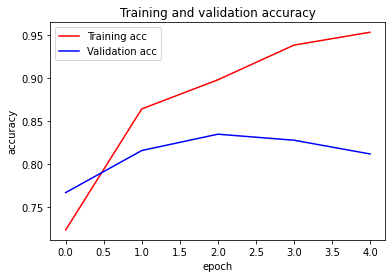

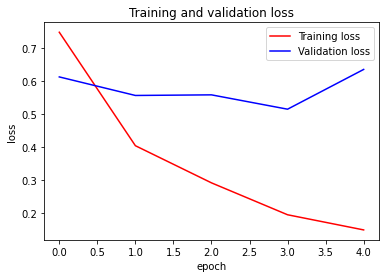

30/30 [==============================] - 2s 64ms/step - loss: 0.5635 - acc: 0.8209
Test Loss: 0.5634675025939941
Test Accuracy: 0.8209424018859863


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

affective_individual     0.0000    0.0000    0.0000         9
infrastucture_damage     0.7595    0.7407    0.7500        81
     not_humantarian     0.8205    0.8889    0.8533       504
      other_relevant     0.8397    0.8468    0.8432       235
    rescue_volunteer     0.9155    0.5159    0.6599       126

           micro avg     0.8274    0.8084    0.8178       955
           macro avg     0.6670    0.5985    0.6213       955
        weighted avg     0.8248    0.8084    0.8085       955
         samples avg     0.8084    0.8084    0.8084       955

Confusion matrix, without normalization


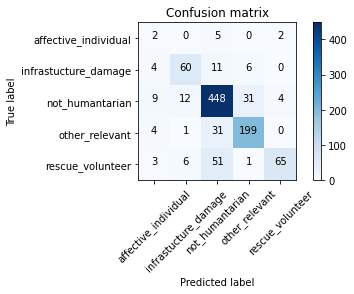

In [ ]:
cnn_evaluation(model1, history, xtest_padded_sequences, test_data,test_labels, class_names=None, model_name=None)

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CrisisMMD_v2.0/crisismmd_datasplit_all/task_humanitarian_text_img_agreed_lab_train.tsv", sep='\t')
df_train.shape

(6126, 9)

In [ ]:
df1=df_train[df_train['label_image']=='affected_individuals']
df1.shape
df2=df_train[df_train['label_image']=='infrastructure_and_utility_damage']
df2.shape
df3=df_train[df_train['label_image']=='not_humanitarian']
df3.shape
df4=df_train[df_train['label_image']=='other_relevant_information']
df4.shape
df5=df_train[df_train['label_image']=='rescue_volunteering_or_donation_effort']
df5.shape
df_train=pd.concat([df1,df2,df3,df4,df5])

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CrisisMMD_v2.0/crisismmd_datasplit_all/task_humanitarian_text_img_agreed_lab_test.tsv", sep='\t')
df_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CrisisMMD_v2.0/crisismmd_datasplit_all/task_humanitarian_text_img_agreed_lab_dev.tsv", sep='\t')

In [ ]:
df11=df_val[df_val['label_image']=='affected_individuals']
df22=df_val[df_val['label_image']=='infrastructure_and_utility_damage']
df55=df_val[df_val['label_image']=='not_humanitarian']
df66=df_val[df_val['label_image']=='other_relevant_information']
df77=df_val[df_val['label_image']=='rescue_volunteering_or_donation_effort']
df_val=pd.concat([df11,df22,df55,df66,df77])
df_val.shape

(998, 9)

In [ ]:
df12=df_test[df_test['label_image']=='affected_individuals']
df23=df_test[df_test['label_image']=='infrastructure_and_utility_damage']
df56=df_test[df_test['label_image']=='not_humanitarian']
df67=df_test[df_test['label_image']=='other_relevant_information']
df78=df_test[df_test['label_image']=='rescue_volunteering_or_donation_effort']
df_test=pd.concat([df12,df23,df56,df67,df78])
df_test.shape

(955, 9)

In [ ]:
df_train= df_train.drop(['tweet_id', 'image_id','image', 'label_text','label'], axis=1)
df_val= df_val.drop(['tweet_id', 'image_id','image', 'label_text','label'], axis=1)
df_test= df_test.drop(['tweet_id', 'image_id','image', 'label_text','label'], axis=1)

In [ ]:
df_train.tweet_text = df_train.tweet_text.apply(preprocess)
df_val.tweet_text = df_val.tweet_text.apply(preprocess)
df_test.tweet_text = df_test.tweet_text.apply(preprocess)

In [ ]:
df_train.reset_index(inplace = True)
df_val.reset_index(inplace = True)
df_test.reset_index(inplace = True)

In [ ]:
!pip install bert-for-tf2
import bert
from bert.tokenization.bert_tokenization import FullTokenizer
import tensorflow_hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = tensorflow_hub.KerasLayer(module_url, trainable=True)

     |████████████████████████████████| 51kB 5.0MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=2bd6fac9a581f560180bbca84d668d6637177607da0ea8818d52da9aa9dc5451
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=14879134cf7e46be41ddf86ae3a173f11d5c385f39eb4e0a9f5e95e75f9d2faa
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=ed7b1f8f6d6a21b120974bd22b93e06ed7c5b09f5add4770fea712e992c728f7
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
#Tokenizer for bert
vocabularyfile = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocabularyfile, do_lower_case)

In [ ]:
#provide embeddings to the text
def embedding(string):
    string = tokenizer.tokenize(string)
            
    string = string[:maxstringlength-2]
    input_sequence = ["[CLS]"] + string + ["[SEP]"]
    pad_len = maxstringlength - len(input_sequence)

    tokens = tokenizer.convert_tokens_to_ids(input_sequence)
    tokens += [0] * pad_len
    pad_masks = [1] * len(input_sequence) + [0] * pad_len
    segment_ids = [0] * maxstringlength
    return tokens, pad_masks, segment_ids

In [ ]:
def formatting(data):
    tokenlist = []
    masklist = []
    segmentlist = []
    for i in range(data.shape[0]):
        tokenlist.append(data[i][0])
        masklist.append(data[i][1])
        segmentlist.append(data[i][2])
    return np.array(tokenlist), np.array(masklist), np.array(segmentlist)

In [ ]:
#converting  all data into tuple for input for bert
maxstringlength = 22
trainingdata = df_train.tweet_text.apply(embedding)
valdata = df_val.tweet_text.apply(embedding)

X_train = formatting(trainingdata)
X_val = formatting(valdata)

testdata=df_test.tweet_text.apply(embedding)
X_test=formatting(testdata)

In [ ]:
noofcategories = df_train["label_image"].nunique()
noofcategories

5

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
import warnings
import datetime
import optparse
import os, errno
import keras.callbacks as callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, CSVLogger, TensorBoard
from gensim.models import KeyedVectors
from keras.layers import Input, Activation, Add, Concatenate, Dropout
from keras.models import load_model
from keras.layers import concatenate
from time import time
import pickle
from keras.layers.normalization import BatchNormalization
import keras
from keras.applications.resnet50 import ResNet50

In [ ]:
def create_cnn():
    # Initialize the input shape and channel dimension, where the number of channels is the last dimension
    model = Sequential() 
    model.add(Flatten(input_shape=train_data.shape[1:])) 
    model.add(Dense(20, activation=keras.layers.LeakyReLU(alpha=0.3))) 
 
    # Return the CNN
    return model        

In [ ]:
def create_bert(bert_layer, noofcategories, maxstringlength=22):
    tokens = tf.keras.Input(shape=(maxstringlength,), dtype=tf.int32, name="tokens")
    masks = tf.keras.Input(shape=(maxstringlength,), dtype=tf.int32, name="masks")
    segments = tf.keras.Input(shape=(maxstringlength,), dtype=tf.int32, name="segments")

    pooled_output, sequence_output = bert_layer([tokens, masks, segments])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.4)(net)
    out = tf.keras.layers.Dense(20, activation='relu')(net)
    
    model = tf.keras.models.Model(inputs=[tokens, masks, segments], outputs=out)
    #model.compile(tf.keras.optimizers.Adam(lr=2e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
bert_model = create_bert(bert_layer, noofcategories, maxstringlength=22)
cnn = create_cnn()
combinedInput = concatenate([bert_model.output, cnn.output])

In [ ]:
# The final fully-connected layer 
x = Dense(10, activation="relu")(combinedInput)
x = Dense(noofcategories, activation="softmax")(x)

In [ ]:
# The final model accepts numerical data on the BERT input and images on the CNN input, outputting a single value
model1 = Model(inputs=[bert_model.input, cnn.input], outputs=x)

In [ ]:
from keras.optimizers import Adam, RMSprop
start = datetime.datetime.now()

# compile the model 
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model1.compile(loss="categorical_crossentropy", metrics=['acc'], optimizer=opt)
 
# train the model
history = model1.fit([X_train, train_data], train_labels, validation_data=([X_val, validation_data], validation_labels), epochs=3, batch_size=50)
 
end = datetime.datetime.now()
print("Time taken to run:", end-start)

Epoch 1/3
123/123 [==============================] - 4650s 38s/step - loss: 0.9751 - acc: 0.6206 - val_loss: 0.7750 - val_acc: 0.6754
Epoch 2/3
123/123 [==============================] - 4618s 38s/step - loss: 0.6317 - acc: 0.7491 - val_loss: 0.8395 - val_acc: 0.6984
Epoch 3/3
123/123 [==============================] - 4608s 37s/step - loss: 0.4621 - acc: 0.8233 - val_loss: 0.8819 - val_acc: 0.6743
Time taken to run: 3:51:16.879245
